#Downloading the dataset

In [ ]:


from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
 99% 803M/812M [00:06<00:00, 100MB/s]
100% 812M/812M [00:06<00:00, 124MB/s]


#Copying images to training,validation and test directories

In [ ]:


import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train14", start_index=0, end_index=4000)
make_subset("validation14", start_index=4000, end_index=4500)
make_subset("test14", start_index=4500, end_index=5000)

#Building the Model

In [ ]:


from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_91 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_89 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_384 (Conv2D)         (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_315 (MaxPooli  (None, 89, 89, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_385 (Conv2D)         (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_316 (MaxPooli  (None, 43, 43, 64)       0         
 ng2D)                                                    

#Configuring the model for training

In [ ]:


model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#Data Processing

In [ ]:


from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train14",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation14",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test14",
    image_size=(180, 180),
    batch_size=32)

Found 8000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [ ]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [ ]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [ ]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


#Displaying the shapes of the data and labels yielded by the Dataset

In [ ]:


for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


#Fitting the model using a Dataset

In [ ]:


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=15,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/15
94/94 [==============================] - 19s 71ms/step - loss: 0.6994 - accuracy: 0.5040 - val_loss: 0.6919 - val_accuracy: 0.4980
Epoch 2/15
94/94 [==============================] - 6s 66ms/step - loss: 0.6845 - accuracy: 0.5703 - val_loss: 0.6601 - val_accuracy: 0.6340
Epoch 3/15
94/94 [==============================] - 6s 61ms/step - loss: 0.6551 - accuracy: 0.6210 - val_loss: 0.6316 - val_accuracy: 0.6620
Epoch 4/15
94/94 [==============================] - 5s 50ms/step - loss: 0.6131 - accuracy: 0.6703 - val_loss: 0.6318 - val_accuracy: 0.6420
Epoch 5/15
94/94 [==============================] - 6s 59ms/step - loss: 0.5802 - accuracy: 0.6977 - val_loss: 0.7498 - val_accuracy: 0.6020
Epoch 6/15
94/94 [==============================] - 5s 49ms/step - loss: 0.5542 - accuracy: 0.7197 - val_loss: 0.6982 - val_accuracy: 0.6260
Epoch 7/15
94/94 [==============================] - 6s 57ms/step - loss: 0.5079 - accuracy: 0.7583 - val_loss: 0.5965 - val_accuracy: 0.6900
Epoch 8/15
9

#Displaying curves of loss and accuracy during training

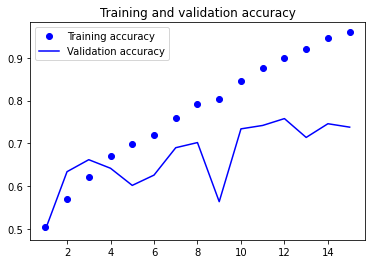

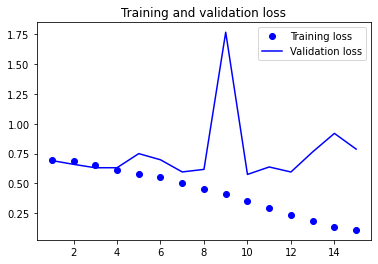

In [ ]:


import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

16/16 [==============================] - 1s 24ms/step - loss: 0.5659 - accuracy: 0.7700
Test accuracy: 0.770


#Using data Augmentation

In [ ]:


data_augmentation = keras.Sequential(
    [
       layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.05),
        layers.RandomZoom(0.01),
    ]
)

#Defining a new convnet that includes image augmentation and dropout

In [ ]:

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=1)(x)
x = layers.Conv2D(filters=64, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=12)(x)
x = layers.Conv2D(filters=128, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=4)(x)
x = layers.Conv2D(filters=256, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.MaxPooling2D(pool_size=1)(x)
x = layers.Conv2D(filters=256, kernel_size=2,strides=(1, 1), activation="relu",padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

#Training the regularized convnet

In [ ]:


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=7,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/7
250/250 [==============================] - 56s 221ms/step - loss: 0.2421 - accuracy: 0.8963 - val_loss: 0.3844 - val_accuracy: 0.8600
Epoch 2/7
250/250 [==============================] - 55s 218ms/step - loss: 0.2297 - accuracy: 0.9003 - val_loss: 0.4356 - val_accuracy: 0.8570
Epoch 3/7
250/250 [==============================] - 55s 219ms/step - loss: 0.2214 - accuracy: 0.9051 - val_loss: 0.4088 - val_accuracy: 0.8500
Epoch 4/7
250/250 [==============================] - 56s 222ms/step - loss: 0.2018 - accuracy: 0.9159 - val_loss: 0.3535 - val_accuracy: 0.8730
Epoch 5/7
250/250 [==============================] - 55s 218ms/step - loss: 0.2027 - accuracy: 0.9171 - val_loss: 0.4032 - val_accuracy: 0.8460
Epoch 6/7
250/250 [==============================] - 55s 221ms/step - loss: 0.1928 - accuracy: 0.9186 - val_loss: 0.3572 - val_accuracy: 0.8620
Epoch 7/7
250/250 [==============================] - 54s 216ms/step - loss: 0.1782 - accuracy: 0.9261 - val_loss: 0.4573 - val_accuracy:

#Evaluating the model on the test set

In [ ]:


test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 31ms/step - loss: 0.3904 - accuracy: 0.8620
Test accuracy: 0.862
